# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | |
Label Smoothing (LS) |  |
Spectral Normalization (SN) |  |
DCGAN + LS + SN | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [2]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 30
    workers = 4
    seed = 2021
    image_size = 32
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"
    test_samples_to_fid = 50000
    save_dir = './cifar10_samples'


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

os.makedirs(f"{CFG.dataroot}/{CFG.save_dir}", exist_ok=True)

for i in range(CFG.test_samples_to_fid):
    img, label = cifar_dataset[i]
    save_image(img, os.path.join(f"{CFG.dataroot}/{CFG.save_dir}", f"cifar10_{i}.png"))


100%|██████████| 170498071/170498071 [00:02<00:00, 58330705.46it/s]


Extracting data/cifar-10-python.tar.gz to data


Label:  6


(array([ 51., 150., 327., 357., 304., 397., 318., 362., 327., 149.,  93.,
         87.,  72.,  48.,  30.]),
 array([-1.        , -0.86666667, -0.73333335, -0.60000002, -0.46666667,
        -0.33333334, -0.2       , -0.06666667,  0.06666667,  0.2       ,
         0.33333334,  0.46666667,  0.60000002,  0.73333335,  0.86666667,
         1.        ]),
 <BarContainer object of 15 artists>)

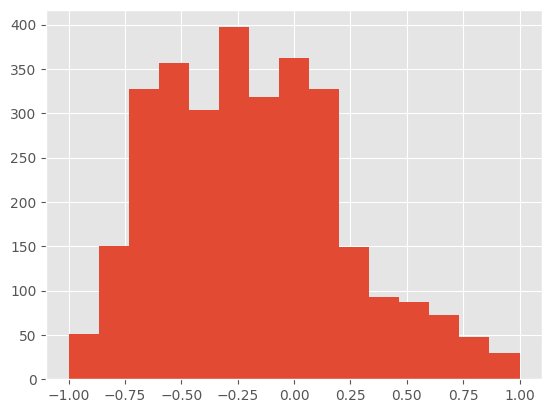

In [3]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

In [4]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return x * 0.5 + 0.5

# show  image sample with matplotlib

Label: 6


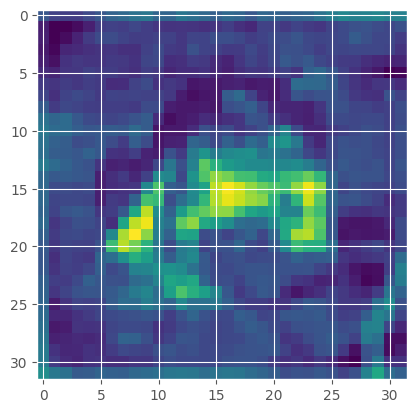

In [5]:
# define the dataloader
img_norm = denorm(img)
plt.imshow(img_norm[2])
print("Label:", label)

# Спектральная нормализация

In [6]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [7]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()  
        )

    def forward(self, input):
        return self.main(input)


# Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: Image (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output: Single probability score
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [8]:
# import torch.nn as nn
# # Generator
# class Generator(nn.Module):
#     def __init__(self, nz, ngf, nc):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             SpectralNorm(nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)),
#             nn.BatchNorm2d(ngf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             SpectralNorm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
#             nn.BatchNorm2d(ngf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             SpectralNorm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
#             nn.BatchNorm2d(ngf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)


# # Discriminator

# class Discriminator(nn.Module):
#     def __init__(self, nc, ndf):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
#             nn.LeakyReLU(0.2, inplace=True),
#             SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid() 
#         )

#     def forward(self, input):
#         output = self.main(input)
#         return output.view(-1, 1).squeeze(1)

In [9]:
# Initialize the Generator and Discriminator
G = Generator(CFG.nz, CFG.ngf, CFG.nc).to(CFG.device)
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [10]:
# Create a random latent vector
latent_vector = torch.randn(2, CFG.nz, 1, 1).to(CFG.device)

# Generate output images from the generator
output_images = G(latent_vector)
output_images.shape

torch.Size([2, 3, 32, 32])

Discriminator Training

In [11]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [12]:
def train_discriminator(discriminator, generator, optimizer, real_images, loss_function, batch_size, latent_size, device):
    # Reset gradients
    reset_grad(optimizer)

    # Label Smoothing for Real Images
    smooth_real_labels = torch.FloatTensor(batch_size).uniform_(1.0, 1.0).to(device)

    # Train on Real Images
    real_predictions = discriminator(real_images)
    real_loss = loss_function(real_predictions, smooth_real_labels)

    # Generate Fake Images
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = generator(z)

    # Label Smoothing for Fake Images
    smooth_fake_labels = torch.FloatTensor(batch_size).uniform_(0.0, 0.0).to(device)

    # Train on Fake Images
    fake_predictions = discriminator(fake_images.detach())
    fake_loss = loss_function(fake_predictions, smooth_fake_labels)

    # Sum losses
    total_loss = real_loss + fake_loss

    # Reset gradients, compute gradients, and adjust the parameters using backprop
    reset_grad(optimizer)
    total_loss.backward()
    optimizer.step()

    # Compute and return the discriminator loss, and the scores for real and fake images
    real_score = real_predictions.mean().item()
    fake_score = fake_predictions.mean().item()
    return total_loss.item(), real_score, fake_score

def reset_grad(optimizer):
    optimizer.zero_grad()

Generator Training

In [13]:
def train_generator(generator, discriminator, optimizer, loss_function, batch_size, latent_size, device):
    # Reset gradients
    reset_grad(optimizer)

    # Generate fake images with added Gaussian noise and calculate loss
    z = np.random.normal(0, 1, (batch_size, latent_size, 1, 1))
    noise = 0.005 * np.random.uniform() * np.amax(z)
    z = z.astype('float32') + noise * np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = generator(z)

    # Create labels that indicate the generated images are real (for the discriminator)
    real_labels = torch.ones(batch_size).to(device)

    # Calculate loss based on how well the generator is able to fool the discriminator
    predictions = discriminator(fake_images)
    g_loss = loss_function(predictions, real_labels)

    # Backpropagation and optimization
    reset_grad(optimizer)
    g_loss.backward()
    optimizer.step()

    return g_loss.item(), fake_images


## Start the training process

In [14]:
def save_fake_images(index, batch_size, latent_size, device, G):
    z = np.random.normal(0, 1, (batch_size, latent_size, 1, 1))
    noise = 0.005 * np.random.uniform() * np.amax(z)
    z = z.astype('float32') + noise * np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)

    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=4)


In [15]:
%%time
from torch.utils.data import DataLoader
import torch.optim as optim

device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size


# Create a DataLoader
data_loader = DataLoader(dataset=cifar_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.workers)

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)


# Assuming G (Generator) and D (Discriminator) are already defined and initialized

# Initialize the optimizers
d_optimizer = optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

# Define the loss function
criterion = nn.BCELoss()


# Start of the training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        batch_size = images.size(0)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, d_optimizer, images, criterion, batch_size, CFG.nz, device)

        # Train the generator
        g_loss, _ = train_generator(G, D, g_optimizer, criterion, batch_size, CFG.nz, device)

        # Inspect the losses
        if (i+1) % 5 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            if (i+1) % 300 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, real_score, fake_score))
    # Sample and save images at the end of each epoch
    save_fake_images(epoch+1, 20, CFG.nz, device, G.eval())

Epoch [0/30], Step [300/391], d_loss: 1.1284, g_loss: 2.0996, D(x): 0.64, D(G(z)): 0.46
Saving fake_images-0001.png
Epoch [1/30], Step [300/391], d_loss: 0.9141, g_loss: 1.9907, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0002.png
Epoch [2/30], Step [300/391], d_loss: 0.8442, g_loss: 1.8087, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0003.png
Epoch [3/30], Step [300/391], d_loss: 0.9380, g_loss: 3.8446, D(x): 0.79, D(G(z)): 0.47
Saving fake_images-0004.png
Epoch [4/30], Step [300/391], d_loss: 1.0391, g_loss: 1.3605, D(x): 0.54, D(G(z)): 0.30
Saving fake_images-0005.png
Epoch [5/30], Step [300/391], d_loss: 1.1913, g_loss: 1.0511, D(x): 0.41, D(G(z)): 0.18
Saving fake_images-0006.png
Epoch [6/30], Step [300/391], d_loss: 1.0008, g_loss: 1.3141, D(x): 0.69, D(G(z)): 0.43
Saving fake_images-0007.png
Epoch [7/30], Step [300/391], d_loss: 0.8105, g_loss: 1.8333, D(x): 0.64, D(G(z)): 0.28
Saving fake_images-0008.png
Epoch [8/30], Step [300/391], d_loss: 0.9050, g_loss: 1.9098, D(x): 0.73

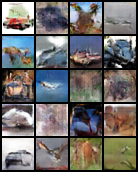

In [26]:
Image(os.path.join(CFG.sample_dir, 'fake_images-0030.png'))

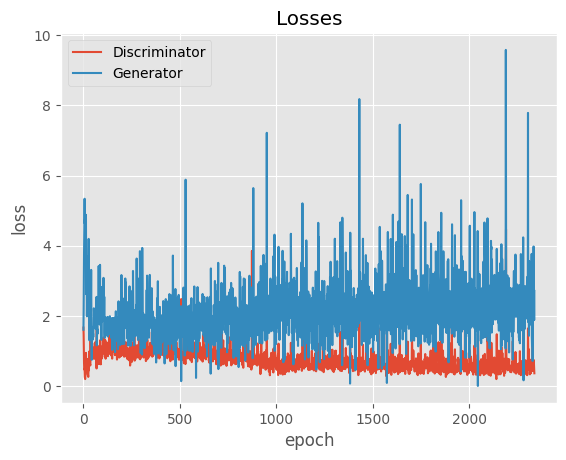

In [27]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

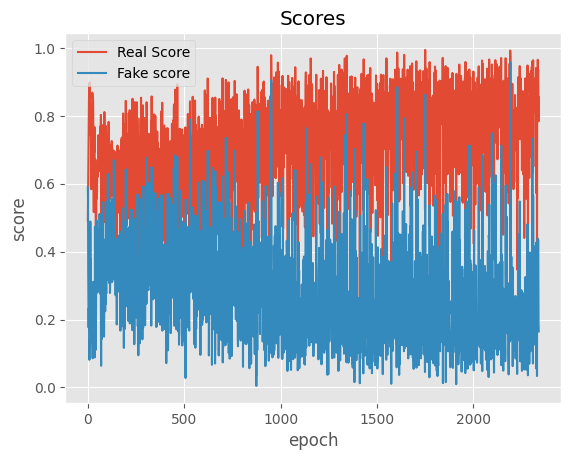

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [29]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

fatal: destination path 'pytorch-gan-metrics' already exists and is not an empty directory.


In [30]:
%%bash
%cd pytorch-gan-metrics
python3 -m pytorch_gan_metrics.calc_fid_stats --path /kaggle/working//data/cifar10_samples --output /kaggle/working/statistics.npz --img_size 32

bash: line 1: fg: no job control
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
CFG.test_samples_to_fid = 30

In [22]:
 # import function from pytorch_gan_metrics
from torch.utils.data import Dataset
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim=CFG.nz):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return CFG.test_samples_to_fid

    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
dataset = GeneratorDataset(G)

# create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, num_workers = 0, shuffle=True)  # Adjust batch_size as needed
# calculate Inception Score
# IS, IS_std = inception_score = get_inception_score(dataloader, batch_size=64, splits=10)

# calculate Frechet Inception Distance
real_data_stats = '/kaggle/working/statistics.npz'  # Replace with the path to your real images
# fid = get_fid(dataloader, real_data_stats, batch_size=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [32]:
# calculate both Inception Score and Frechet Inception Distance
inception_score, fid = get_inception_score_and_fid(dataloader, real_data_stats, batch_size=64, splits=1)

In [33]:
inception_score, fid

((4.143703575485435, 0.0), 258.0294896279589)

Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | 4.14 | 258.0 |
Label Smoothing (LS) | 4.14 | 258.0 |
Spectral Normalization (SN) | 4.93 | 256.23 |
DCGAN + LS + SN | 4.40 | 258.31 |
CIFAR10 | 10.98 ± 0.22 | 3.1508 |